# <center><font color='magenta'>**Assignment 1 for DA3**</font></center>
### <center>Central European University 2025</center>
### <center>Airbnb Pricing Model: Predictive Analysis for Athens & Naples (2024 Q2 & Q3)</center>

In [1]:
import os
import sys
import time
import datetime
import io
import ast
import re
import requests
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from geopy.distance import geodesic
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from stargazer import stargazer
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import patsy
from matplotlib.ticker import PercentFormatter

/Users/karolytakacs/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## **Introduction**
Pricing Airbnb listings effectively requires a **data-driven approach** to optimize revenue while staying competitive.  
I decided to explore **Athens and Naples**, two major **Mediterranean cities** known for their **rich history, strong tourism industry, and dynamic short-term rental markets**.  
Both cities attract millions of visitors annually, making them ideal test cases for a **predictive pricing model**.

## **Objectives**
### **Data Selection & Preparation**
- Extract Airbnb listings for **Athens and Naples** for **Q2 and Q3 of 2024**.
- Perform **data wrangling**, including **feature extraction** and **missing value imputation**.

### **Model Development**
Train and evaluate **five predictive models** to determine the best approach for Airbnb pricing:
- **Ordinary Least Squares (OLS)**
- **LASSO Regression**
- **Random Forest**
- **Boosting (XGBoost)**
- **Boosting II (LightGBM)**

### **Model Comparison**
- Evaluate models based on **fit (accuracy) and computational efficiency**.
- Present a **horserace table** comparing performance metrics.

### **Model Analysis**
- Investigate **feature importance** for **Random Forest & Boosting models**.
- Compare the **top 10 influential factors** affecting Airbnb prices.

### **Live Testing & Validation**
- Test models on **later quarters** and **a different city** to check robustness.
- Analyze how models perform across **new datasets**.

## **Expected Outcomes**
By the end of this study, we aim to:
 - Identify the **best model** for Airbnb price prediction.  
 - Understand the **key factors** driving Airbnb prices in **Athens and Naples**.  
 - Assess how well models **generalize** over time and across **different cities**.  
 - Provide **data-backed insights** for Airbnb hosts and investors.  

**Let's dive in and build an effective Airbnb pricing model!**


## Get Data

In [2]:
def download_and_load_csv(url, save_path="./data"):
    """
    Downloads a ZIP file from a URL, extracts it to a specified path, and loads the CSV file into a DataFrame.

    Parameters:
    - url (str): The direct URL to the ZIP file.
    - save_path (str): Directory where the extracted CSV file should be saved. Default is './data'.

    Returns:
    - pd.DataFrame: The loaded dataset as a Pandas DataFrame.
    """
    os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist

    # Download and extract the ZIP file
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content), "r") as zip_ref:
            csv_filename = zip_ref.namelist()[0]  # Get the CSV file name
            zip_ref.extract(csv_filename, save_path)  # Extract to the specified path

        extracted_file_path = os.path.join(save_path, csv_filename)  # Full path to extracted file
        print(f"Dataset extracted to: {extracted_file_path}")

        # Load the extracted dataset
        return pd.read_csv(extracted_file_path)
    else:
        print(f"Failed to download dataset from {url}")
        return None

# Define URLs
urls = {
    "athens_q2": "https://github.com/Karoly97/DA3/raw/main/Athens_2024_Q2.csv.zip",
    "athens_q3": "https://github.com/Karoly97/DA3/raw/main/Athens_2024_Q3.csv.zip",
    "naples_q3": "https://github.com/Karoly97/DA3/raw/main/Naples_2024_Q3.csv.zip"
}

# Download and load datasets
df_athens_q2 = download_and_load_csv(urls["athens_q2"])
df_athens_q3 = download_and_load_csv(urls["athens_q3"])
df_naples_q3 = download_and_load_csv(urls["naples_q3"])


Dataset extracted to: ./data/Athens_2024_Q2.csv
Dataset extracted to: ./data/Athens_2024_Q3.csv
Dataset extracted to: ./data/Naples_2024_Q3.csv


In [3]:
df_athens_q2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13274 entries, 0 to 13273
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            13274 non-null  int64  
 1   listing_url                                   13274 non-null  object 
 2   scrape_id                                     13274 non-null  int64  
 3   last_scraped                                  13274 non-null  object 
 4   source                                        13274 non-null  object 
 5   name                                          13274 non-null  object 
 6   description                                   13013 non-null  object 
 7   neighborhood_overview                         7680 non-null   object 
 8   picture_url                                   13274 non-null  object 
 9   host_id                                       13274 non-null 

### Feature Engineering

In [4]:
# Define the center of Athens (Syntagma Square)
athens_center_coords = (37.9755, 23.7349)  # (latitude, longitude)
# Function to calculate distance from Athens center
def calculate_distance(row):
    listing_coords = (row['latitude'], row['longitude'])
    return geodesic(athens_center_coords, listing_coords).kilometers
# Create a new column for distance
df_athens_q2['distance_from_center_km'] = df_athens_q2.apply(calculate_distance, axis=1)


In [5]:
# Convert 'price' column to numeric
df_athens_q2['price'] = df_athens_q2['price'].replace('[\$,]', '', regex=True).astype(float)

# Fill missing numerical values with median to avoid data loss
df_athens_q2.fillna(df_athens_q2.median(numeric_only=True), inplace=True)


# Define boolean-like columns
bool_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']

# Convert boolean-like columns to 0/1
for col in bool_columns:
    df_athens_q2[col] = df_athens_q2[col].map({'t': 1, 'f': 0})


# Update list with additional amenities
top_amenities = [
    "Wifi", "TV", "Kitchen", "Heating", "AC", "Washer", "Dryer", "Elevator", 
    "Free parking", "Pool", "Gym", "Smoke detector", "Fire extinguisher", "Hot tub"
]

# Convert amenities into binary variables (0/1)
for amenity in top_amenities:
    df_athens_q2[f"d_{amenity.lower().replace(' ', '')}"] = df_athens_q2["amenities"].str.contains(amenity, na=False).astype(int)

In [6]:
df_athens_q2.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,d_ac,d_washer,d_dryer,d_elevator,d_freeparking,d_pool,d_gym,d_smokedetector,d_fireextinguisher,d_hottub
0,10595,https://www.airbnb.com/rooms/10595,20240626035544,2024-06-26,city scrape,"3 bedrooms, 2 bathrooms, 2nd floor with elevator",The apartment is 3-bedroom apartment with 2-ba...,Ampelokipi district is nice multinational and ...,https://a0.muscache.com/pictures/hosting/Hosti...,37177,...,1,0,0,0,0,0,0,0,0,0
1,10990,https://www.airbnb.com/rooms/10990,20240626035544,2024-06-26,city scrape,Athens Quality Apartments - Deluxe Apartment,Athens Quality Apartments - Deluxe apartment i...,Ampelokipi district is nice multinational and ...,https://a0.muscache.com/pictures/miso/Hosting-...,37177,...,1,0,0,0,0,0,0,0,0,0
2,10993,https://www.airbnb.com/rooms/10993,20240626035544,2024-06-26,city scrape,Athens Quality Apartments - Studio,The Studio is an <br />-excellent located <br ...,Ampelokipi district is nice multinational and ...,https://a0.muscache.com/pictures/107309527/848...,37177,...,1,0,0,0,0,0,0,0,0,0
3,10995,https://www.airbnb.com/rooms/10995,20240626035544,2024-06-26,city scrape,"AQA-No2 1-bedroom, smart tv, fiber connection,","AQA No2 is 1-bedroom apartment (47m2), on the ...",Ampelokipi district is nice multinational and ...,https://a0.muscache.com/pictures/hosting/Hosti...,37177,...,1,0,0,0,0,0,0,0,0,0
4,27262,https://www.airbnb.com/rooms/27262,20240626035544,2024-06-26,city scrape,Athens Quality Apartments - Ground floor apart...,THE MATTRESS - KING KOIL - Camden Luxury 160x2...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,37177,...,1,0,0,0,0,0,0,0,0,0


In [7]:
# Columns to drop
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'host_since',
    'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_about', 'host_response_time', 
    'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'amenities', 'has_availability',
    'calendar_updated', 'calendar_last_scraped', 'license', 'neighbourhood_group_cleansed', 'host_acceptance_rate',
    'host_location', 'host_id', 'first_review', 'last_review', 'bathrooms_text', 'latitude','longitude', 'host_response_rate'  
]

# Drop only the columns that exist in the DataFrame
df_athens_q2 = df_athens_q2.drop(columns=[col for col in columns_to_drop if col in df_athens_q2.columns])

# Assuming df_athens_q2 is already loaded
df_athens_q2 = df_athens_q2.dropna(subset=['host_is_superhost'])



In [8]:
df_athens_q2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12505 entries, 0 to 13273
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_is_superhost                             12505 non-null  float64
 1   host_listings_count                           12505 non-null  int64  
 2   host_total_listings_count                     12505 non-null  int64  
 3   host_verifications                            12505 non-null  object 
 4   host_has_profile_pic                          12505 non-null  int64  
 5   host_identity_verified                        12505 non-null  int64  
 6   neighbourhood_cleansed                        12505 non-null  object 
 7   property_type                                 12505 non-null  object 
 8   room_type                                     12505 non-null  object 
 9   accommodates                                  12505 non-null  int6

In [9]:
df_athens_q2.head()

,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,...,d_ac,d_washer,d_dryer,d_elevator,d_freeparking,d_pool,d_gym,d_smokedetector,d_fireextinguisher,d_hottub
0,1.0,8,10,"['email', 'phone']",1,1,ΑΜΠΕΛΟΚΗΠΟΙ,Entire condo,Entire home/apt,10,...,1,0,0,0,0,0,0,0,0,0
1,1.0,8,10,"['email', 'phone']",1,1,ΑΜΠΕΛΟΚΗΠΟΙ,Entire rental unit,Entire home/apt,4,...,1,0,0,0,0,0,0,0,0,0
2,1.0,8,10,"['email', 'phone']",1,1,ΑΜΠΕΛΟΚΗΠΟΙ,Entire rental unit,Entire home/apt,2,...,1,0,0,0,0,0,0,0,0,0
3,1.0,8,10,"['email', 'phone']",1,1,ΑΜΠΕΛΟΚΗΠΟΙ,Entire rental unit,Entire home/apt,4,...,1,0,0,0,0,0,0,0,0,0
4,1.0,8,10,"['email', 'phone']",1,1,ΑΜΠΕΛΟΚΗΠΟΙ,Entire rental unit,Entire home/apt,2,...,1,0,0,0,0,0,0,0,0,0


In [10]:
# How are extreme prices distributed?
df_athens_q2.price.quantile([0.75, 0.8, 0.9, 0.95, 0.99, 0.995]).map('{:,.2f}'.format)

0.750      118.00
0.800      132.00
0.900      189.00
0.950      269.80
0.990      632.92
0.995    1,000.00
Name: price, dtype: object

In [11]:
# We pick USD 270, above which all observations are excluded in the charts below.
df_athens_q2=df_athens_q2[df_athens_q2.price<270]

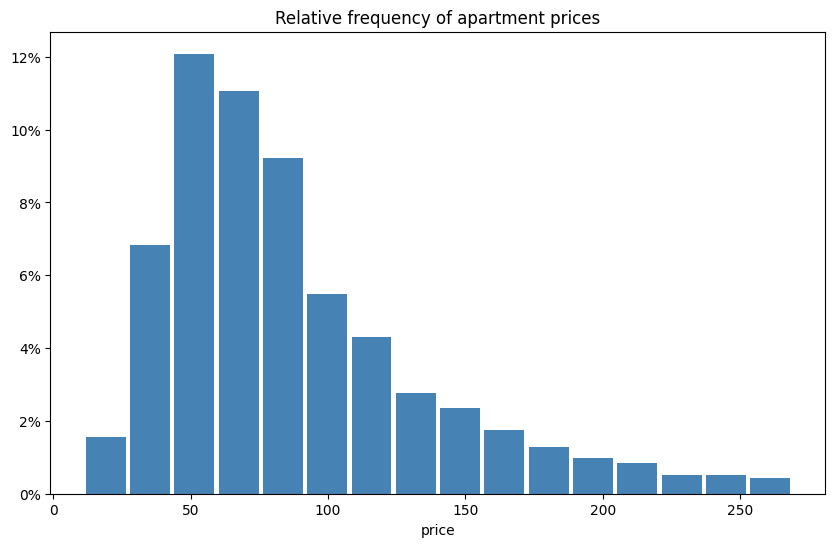

In [12]:
# relative frequencies with matplotlib
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(df_athens_q2.price, bins = 16, density = True, rwidth = 0.9, color = 'steelblue')
ax.set_xlabel('price')
# ax.grid()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=0.1, decimals = 0))
ax.set_title('Relative frequency of apartment prices')
plt.show()

In [13]:
df_athens_q2.room_type.value_counts()

room_type
Entire home/apt    10996
Private room         778
Shared room           56
Hotel room            49
Name: count, dtype: int64

In [14]:
df_athens_q2.property_type.value_counts()

property_type
Entire rental unit                    7646
Entire condo                          2577
Private room in rental unit            318
Entire home                            261
Entire serviced apartment              235
Room in hotel                          158
Entire loft                            117
Private room in condo                  112
Room in aparthotel                     102
Room in boutique hotel                  43
Private room in serviced apartment      36
Private room in home                    32
Room in serviced apartment              31
Shared room in hostel                   24
Private room in bed and breakfast       21
Entire vacation home                    17
Tiny home                               15
Entire townhouse                        14
Private room in hostel                  14
Shared room in rental unit              13
Private room in guesthouse              13
Shared room in home                      9
Private room in guest suite             

In [15]:

property_type_mapping = {
    "Entire rental unit": "Entire Apartment/Condo",
    "Entire condo": "Entire Apartment/Condo",
    "Entire home": "Entire Apartment/Condo",
    "Entire serviced apartment": "Entire Apartment/Condo",
    "Entire loft": "Entire Apartment/Condo",
    
    "Private room in rental unit": "Private Room",
    "Private room in condo": "Private Room",
    "Private room in serviced apartment": "Private Room",
    "Private room in home": "Private Room",
    "Private room in guesthouse": "Private Room",
    "Private room in townhouse": "Private Room",
    "Private room in hostel": "Private Room",
    "Private room in earthen home": "Private Room",
    "Private room in tent": "Private Room",
    "Private room in casa particular": "Private Room",
    "Private room in bed and breakfast": "Private Room",
    "Private room in guest suite": "Private Room",
    "Private room": "Private Room",
    
    "Room in hotel": "Hotel/Aparthotel",
    "Room in aparthotel": "Hotel/Aparthotel",
    "Room in boutique hotel": "Hotel/Aparthotel",
    "Room in serviced apartment": "Hotel/Aparthotel",
    "Shared room in hotel": "Hotel/Aparthotel",
    
    "Shared room in rental unit": "Shared Room",
    "Shared room in hostel": "Shared Room",
    "Shared room in guesthouse": "Shared Room",
    "Shared room in home": "Shared Room",
    "Shared room in bed and breakfast": "Shared Room",
    "Shared room in townhouse": "Shared Room",
    
    "Entire vacation home": "Luxury/Vacation Home",
    "Entire townhouse": "Luxury/Vacation Home",
    "Entire guesthouse": "Luxury/Vacation Home",
    "Entire guest suite": "Luxury/Vacation Home",
    "Entire villa": "Luxury/Vacation Home",
    "Tiny home": "Luxury/Vacation Home",
    "Cycladic home": "Luxury/Vacation Home",
    "Casa particular": "Luxury/Vacation Home",
    "Earthen home": "Luxury/Vacation Home",
    "Camper/RV": "Luxury/Vacation Home",
}

df_athens_q2.loc[:, "property_type_grouped"] = df_athens_q2["property_type"].map(property_type_mapping).fillna("Other")
# Drop the original property_type column
df_athens_q2.drop(columns=["property_type"], inplace=True)

In [16]:
df_athens_q2.property_type_grouped.value_counts()

property_type_grouped
Entire Apartment/Condo    10836
Private Room                564
Hotel/Aparthotel            336
Luxury/Vacation Home         79
Shared Room                  54
Other                        10
Name: count, dtype: int64

In [17]:
df_athens_q2.neighbourhood_cleansed.value_counts()

neighbourhood_cleansed
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              2183
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                  986
ΝΕΟΣ ΚΟΣΜΟΣ                          919
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ             907
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ     793
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ                      523
ΠΑΓΚΡΑΤΙ                             483
ΑΜΠΕΛΟΚΗΠΟΙ                          414
ΚΟΛΩΝΑΚΙ                             383
ΑΚΡΟΠΟΛΗ                             340
ΠΕΤΡΑΛΩΝΑ                            337
ΘΗΣΕΙΟ                               324
ΚΕΡΑΜΕΙΚΟΣ                           316
ΚΥΨΕΛΗ                               263
ΓΟΥΔΙ                                227
ΣΤΑΔΙΟ                               202
ΙΛΙΣΙΑ                               201
ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ                     159
ΝΙΡΒΑΝΑ                              155
ΠΑΤΗΣΙΑ                              153
ΛΥΚΑΒΗΤΤΟΣ                           147
ΑΝΩ ΚΥΨΕΛΗ                           131
ΖΑΠΠΕΙΟ                              123
ΓΚΥΖΗ                             

In [18]:
# Count occurrences of each neighbourhood
neighbourhood_counts = df_athens_q2["neighbourhood_cleansed"].value_counts()

# Identify neighbourhoods with count < 50
small_neighbourhoods = neighbourhood_counts[neighbourhood_counts < 50].index

# Replace them with "Other"
df_athens_q2.loc[df_athens_q2["neighbourhood_cleansed"].isin(small_neighbourhoods), "neighbourhood_cleansed"] = "Other"

In [19]:
df_athens_q2.room_type.value_counts()

room_type
Entire home/apt    10996
Private room         778
Shared room           56
Hotel room            49
Name: count, dtype: int64

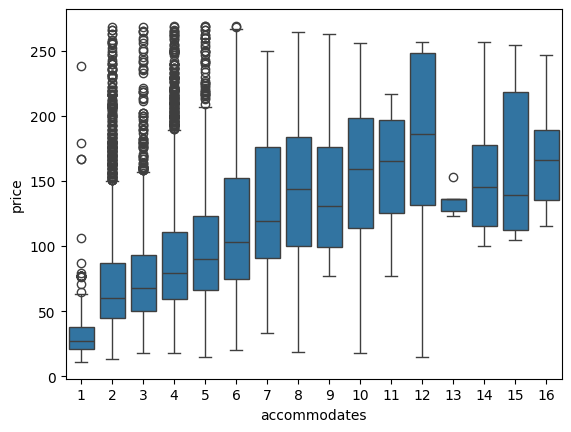

In [20]:
sns.boxplot(data = df_athens_q2, x = 'accommodates', y = 'price', orient = 'v')
plt.show()

# Modelling 

## OLS

In [21]:
reg1 = smf.ols("price ~ distance_from_center_km +  + review_scores_rating", data = df_athens_q2).fit(cov_type="HC0")

In [22]:
print(reg1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     1190.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:37:19   Log-Likelihood:                -61918.
No. Observations:               11879   AIC:                         1.238e+05
Df Residuals:                   11876   BIC:                         1.239e+05
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [23]:
reg2 = smf.ols("price ~ distance_from_center_km + accommodates", data = df_athens_q2).fit(cov_type="HC0")
reg3 = smf.ols(
    "price ~ distance_from_center_km + accommodates + property_type_grouped",
    data = df_athens_q2,
).fit(cov_type="HC0")
reg4 = smf.ols(
    "price ~ distance_from_center_km + accommodates + property_type_grouped + review_scores_rating",
    data = df_athens_q2,
).fit(cov_type="HC0")
reg5 = smf.ols(
    "price ~ distance_from_center_km + accommodates + property_type_grouped + review_scores_rating +host_is_superhost + availability_365",
    data = df_athens_q2,
).fit(cov_type="HC0")

In [24]:
models = [reg1, reg2, reg3, reg4, reg5]
robustcov_results=[]

for i, model in enumerate(models):
    result=model.get_robustcov_results(cov_type='HC1').summary()
    robustcov_results.append(result)
    print()
    print(f'Regression: reg{i+1}')
    print(result)


Regression: reg1
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     1190.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:37:19   Log-Likelihood:                -61918.
No. Observations:               11879   AIC:                         1.238e+05
Df Residuals:                   11876   BIC:                         1.239e+05
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercep

In [25]:
bic = [round(x.bic, 2) for x in [reg1,reg2,reg3,reg4,reg5]]
sg = stargazer.Stargazer([reg1,reg2,reg3,reg4,reg5])
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg

In [26]:
#Measure training time for reg5
start_time = time.time()
reg5 = smf.ols(
    "price ~ distance_from_center_km + accommodates + property_type_grouped + review_scores_rating + host_is_superhost + availability_365",
    data=df_athens_q2,
).fit(cov_type="HC0")
training_time_reg5 = round(time.time() - start_time, 2)

# Print results with robust covariance and training time
print(f"\nRegression: reg5")
print(f"Training Time: {training_time_reg5} seconds")
print(reg5.get_robustcov_results(cov_type='HC1').summary())
# Extract R² (R-squared)
r2_ols5 = reg5.rsquared

# Extract RMSE (Root Mean Squared Error)
rmse_ols5 = np.sqrt(reg5.mse_resid)

# Store in a dictionary
ols_metrics = {
    "OLS (reg5)": {
        "RMSE": round(rmse_ols5, 2),
        "R²": round(r2_ols5, 3)
    }
}

print(ols_metrics)


Regression: reg5
Training Time: 0.3 seconds
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     547.6
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:37:20   Log-Likelihood:                -60449.
No. Observations:               11879   AIC:                         1.209e+05
Df Residuals:                   11868   BIC:                         1.210e+05
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

## Lasso

In [27]:
# Feature Definitions
basic_lev = ("distance_from_center_km", "beds", "room_type", "availability_365")
basic_add = ("bathrooms", "bedrooms")
reviews = ("review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_value")
amenities = [
    'd_wifi', 'd_tv', 'd_kitchen', 'd_heating', 'd_ac', 'd_washer', 'd_dryer',
    'd_elevator', 'd_freeparking', 'd_pool', 'd_gym', 'd_smokedetector',
    'd_fireextinguisher', 'd_hottub'
]

In [28]:
# Interaction and additional terms
X1 = ("accommodates", "distance_from_center_km")
X2 = ("review_scores_rating:distance_from_center_km",)  # Corrected to use colon for interaction in patsy
X3 = "(distance_from_center_km + accommodates + property_type_grouped + review_scores_rating) * (" + "+".join(amenities) + ")"

In [29]:
# Model formulas
modellev1 = "~ accommodates"
modellev2 = "~ " + "+".join(basic_lev)
modellev3 = "~ " + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev4 = modellev3  # Same as modellev3
modellev5 = modellev3 + "+" + "+".join(X1)
modellev6 = modellev5 + "+" + "+".join(X2)
modellev7 = modellev6 + "+" + "+".join(amenities)
modellev8 = modellev7 + "+" + X3

In [30]:
# Prepare data
smp_size = round(0.2 * df_athens_q2.shape[0]) - 1
y, X = patsy.dmatrices("price " + modellev8, df_athens_q2)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=smp_size, random_state=10)

# Define lambda values
lambdas = [i / 100 for i in range(5, 100, 5)] 

# Train Lasso with different lambdas and measure total training time
train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))
start_time_lambda = time.time()

for ind, lam in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {lam:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha=lam, random_state=20250217)
    reg.fit(X_train, y_train.ravel())  # ravel() to convert y_train to 1D array
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

lambda_training_time = round(time.time() - start_time_lambda, 2)  

# Find optimal lambda
r_squared_df = pd.DataFrame({
    "$R^2$ Test set": test_r_squared,
    "$R^2$ Training set": train_r_squared,
    "lambda": lambdas
}).melt(id_vars=["lambda"])
r_squared_df["variable"] = r_squared_df["variable"].astype("category").cat.reorder_categories(["$R^2$ Training set", "$R^2$ Test set"])

df_lam = pd.DataFrame(test_r_squared * 100, columns=['R_squared'])
df_lam['lambda'] = lambdas
optimal_lambda_idx = df_lam['R_squared'].idxmax()
optimal_lambda = df_lam.loc[optimal_lambda_idx, 'lambda']

# Final Lasso model with optimal lambda and measure training time
start_time_final = time.time()
lasso_model = Lasso(alpha=optimal_lambda, random_state=20250217)
lasso_model.fit(X_train, y_train.ravel())
final_training_time = round(time.time() - start_time_final, 2)  
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)

# Compute final metrics
rmse_lasso_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_lasso_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_lasso_train = r2_score(y_train, y_pred_train)
r2_lasso_test = r2_score(y_test, y_pred_test)

# Print results
print("\nLasso Model Results (Athens Q2)")
print(f"Lambda Tuning Time: {lambda_training_time} seconds (across {len(lambdas)} runs)")
print(f"Final Model Training Time: {final_training_time} seconds")
print(f"Optimal Lambda: {optimal_lambda:.2f}")
print("Train Set:")
print(f"  RMSE: {rmse_lasso_train:.2f}")
print(f"  R²: {r2_lasso_train:.3f}")
print("Test Set:")
print(f"  RMSE: {rmse_lasso_test:.2f}")
print(f"  R²: {r2_lasso_test:.3f}")

Run:  0, lambda: 0.05, start: 2025-03-02 23:37:20
Run:  1, lambda: 0.10, start: 2025-03-02 23:37:24
Run:  2, lambda: 0.15, start: 2025-03-02 23:37:25
Run:  3, lambda: 0.20, start: 2025-03-02 23:37:25
Run:  4, lambda: 0.25, start: 2025-03-02 23:37:25
Run:  5, lambda: 0.30, start: 2025-03-02 23:37:26
Run:  6, lambda: 0.35, start: 2025-03-02 23:37:26
Run:  7, lambda: 0.40, start: 2025-03-02 23:37:26
Run:  8, lambda: 0.45, start: 2025-03-02 23:37:26
Run:  9, lambda: 0.50, start: 2025-03-02 23:37:27
Run: 10, lambda: 0.55, start: 2025-03-02 23:37:27
Run: 11, lambda: 0.60, start: 2025-03-02 23:37:27
Run: 12, lambda: 0.65, start: 2025-03-02 23:37:28
Run: 13, lambda: 0.70, start: 2025-03-02 23:37:28
Run: 14, lambda: 0.75, start: 2025-03-02 23:37:28
Run: 15, lambda: 0.80, start: 2025-03-02 23:37:29
Run: 16, lambda: 0.85, start: 2025-03-02 23:37:29
Run: 17, lambda: 0.90, start: 2025-03-02 23:37:29
Run: 18, lambda: 0.95, start: 2025-03-02 23:37:29

Lasso Model Results (Athens Q2)
Lambda Tuning Tim

## Random Forest

In [31]:
# Check if required variables are defined
required_vars = ['columns_to_drop', 'df_athens_q2']
for var in required_vars:
    if var not in globals():
        raise NameError(f"Required variable '{var}' is not defined.")

# Load and Prepare Data
df = df_athens_q2.copy()

# Drop specified columns
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors="ignore")

# Identify non-numeric columns (excluding 'price')
non_numeric_cols = [col for col in df.select_dtypes(include=["object"]).columns if col != "price"]

# Handle categorical variables with one-hot encoding
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)

# Convert any list-like string values (e.g., "['email', 'phone']") to counts safely
def count_list_values(value):
    if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
        try:
            return len(ast.literal_eval(value))  # Safely parse string to list & count
        except (ValueError, SyntaxError):
            return 0  # Return 0 if parsing fails
    return value

df = df.apply(lambda x: x.map(count_list_values) if x.dtype == "object" else x)

# Ensure target variable is numeric and drop NaN values
target = "price"
if target not in df.columns:
    raise ValueError(f"Target variable '{target}' not found in dataset.")
df[target] = pd.to_numeric(df[target], errors="coerce")
df = df.dropna(subset=[target])  # Drop rows with missing price values

# Define features (X) and target (y)
X = df.drop(columns=[target])
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store feature names for later use
rf_feature_names_memory = X_train.columns.tolist()

# Train Random Forest Model
start_time = time.time()
rf_model_memory = RandomForestRegressor(
    n_estimators=100,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1  # Use all available cores for faster training
)
rf_model_memory.fit(X_train, y_train)
rf_training_time = round(time.time() - start_time, 2)

# Predict & Evaluate Performance
y_pred_train = rf_model_memory.predict(X_train)
y_pred_test = rf_model_memory.predict(X_test)

# Compute RMSE & R² for both train and test sets
rmse_rf_train = round(mean_squared_error(y_train, y_pred_train, squared=False), 2)
rmse_rf_test = round(mean_squared_error(y_test, y_pred_test, squared=False), 2)
r2_rf_train = round(r2_score(y_train, y_pred_train), 3)
r2_rf_test = round(r2_score(y_test, y_pred_test), 3)

# Extract Feature Importances from the Random Forest Model
rf_feature_importance = pd.DataFrame({
    "Feature": rf_feature_names_memory,
    "Importance": rf_model_memory.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Print results
print("\nRandom Forest Model Training Results")
print(f"Training Time: {rf_training_time} seconds")
print("Train Set:")
print(f"  RMSE: {rmse_rf_train}")
print(f"  R²: {r2_rf_train}")
print("Test Set:")
print(f"  RMSE: {rmse_rf_test}")
print(f"  R²: {r2_rf_test}")


Random Forest Model Training Results
Training Time: 0.47 seconds
Train Set:
  RMSE: 11.49
  R²: 0.943
Test Set:
  RMSE: 31.74
  R²: 0.59


## XGBoost

In [32]:
# Define target variable
target = "price"

# Define categorical, numerical, and binary features
categorical_features = ["neighbourhood_cleansed", "room_type", "property_type_grouped"]
numerical_features = [
    "host_listings_count", "host_total_listings_count", "accommodates", "bathrooms",
    "bedrooms", "beds", "minimum_nights", "maximum_nights", "minimum_minimum_nights",
    "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights",
    "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "availability_30",
    "availability_60", "availability_90", "availability_365", "number_of_reviews",
    "number_of_reviews_ltm", "number_of_reviews_l30d", "review_scores_rating",
    "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin",
    "review_scores_communication", "review_scores_location", "review_scores_value",
    "calculated_host_listings_count", "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms",
    "reviews_per_month", "distance_from_center_km"
]
binary_features = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable",
    "d_wifi", "d_tv", "d_kitchen", "d_heating", "d_ac", "d_washer", "d_dryer",
    "d_elevator", "d_freeparking", "d_pool", "d_gym", "d_smokedetector", "d_fireextinguisher", "d_hottub"
]


In [33]:
# Check if required variables are defined
required_vars = ['numerical_features', 'binary_features', 'categorical_features', 'target', 'df_athens_q2']
for var in required_vars:
    if var not in globals():
        raise NameError(f"Required variable '{var}' is not defined.")

# Combine all features
features = numerical_features + binary_features + categorical_features

# Create a copy to avoid modifying the original dataset
df_xgb = df_athens_q2.copy()

# Drop the host_verifications column if it exists
if "host_verifications" in df_xgb.columns:
    df_xgb.drop(columns=["host_verifications"], inplace=True)

# Validate and convert categorical variables to category dtype
for col in categorical_features:
    if col in df_xgb.columns:
        df_xgb[col] = df_xgb[col].astype("category")
    else:
        print(f"Warning: Categorical feature '{col}' not found in dataset.")

# Ensure target variable is numeric and drop any NaN values
if target not in df_xgb.columns:
    raise ValueError(f"Target variable '{target}' not found in dataset.")
df_xgb[target] = pd.to_numeric(df_xgb[target], errors="coerce")
df_xgb = df_xgb.dropna(subset=[target]) 

# Split dataset into train and test sets
X = df_xgb.drop(columns=[target])
y = df_xgb[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model with categorical support enabled
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    tree_method="hist",
    eval_metric="rmse",
    enable_categorical=True,
    random_state=42
)

# Measure training time
start_time = time.time()
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
xgb_training_time = round(time.time() - start_time, 2) 

# Store model and feature names in memory
xgb_model_memory = xgb_model  # Store trained model
xgb_feature_names_memory = X_train.columns.tolist()  

# Make predictions
y_pred_train = xgb_model_memory.predict(X_train)
y_pred_test = xgb_model_memory.predict(X_test)

# Compute RMSE and R² for both train and test sets
rmse_xgb_train = round(mean_squared_error(y_train, y_pred_train, squared=False), 2)
rmse_xgb_test = round(mean_squared_error(y_test, y_pred_test, squared=False), 2)
r2_xgb_train = round(r2_score(y_train, y_pred_train), 3)
r2_xgb_test = round(r2_score(y_test, y_pred_test), 3)

# Print results
print("\nXGBoost Model Training Results")
print(f"Training Time: {xgb_training_time} seconds")
print("Train Set:")
print(f"  RMSE: {rmse_xgb_train}")
print(f"  R²: {r2_xgb_train}")
print("Test Set:")
print(f"  RMSE: {rmse_xgb_test}")
print(f"  R²: {r2_xgb_test}")

# Feature Importance
feature_importance_xgb = pd.DataFrame({"Feature": X_train.columns, "Importance": xgb_model_memory.feature_importances_})
feature_importance_xgb = feature_importance_xgb.sort_values(by="Importance", ascending=False)


XGBoost Model Training Results
Training Time: 2.23 seconds
Train Set:
  RMSE: 13.97
  R²: 0.916
Test Set:
  RMSE: 29.26
  R²: 0.651


## LightGBM

In [34]:
# Check if required variables are defined
required_vars = ['numerical_features', 'binary_features', 'categorical_features', 'target', 'df_athens_q2']
for var in required_vars:
    if var not in globals():
        raise NameError(f"Required variable '{var}' is not defined.")

# Combine all features
features = numerical_features + binary_features + categorical_features

# Create a copy to avoid modifying the original dataset
df_lgb = df_athens_q2.copy()

# Drop the host_verifications column if it exists
if "host_verifications" in df_lgb.columns:
    df_lgb.drop(columns=["host_verifications"], inplace=True)

# One-hot encode categorical variables
df_lgb = pd.get_dummies(df_lgb, columns=categorical_features, drop_first=True)

# Ensure target variable is numeric and drop any NaN values
if target not in df_lgb.columns:
    raise ValueError(f"Target variable '{target}' not found in dataset.")
df_lgb[target] = pd.to_numeric(df_lgb[target], errors="coerce")
df_lgb = df_lgb.dropna(subset=[target]) 

# Split dataset
X = df_lgb.drop(columns=[target])
y = df_lgb[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define LightGBM parameters
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": 6,
    "n_estimators": 500,
    "verbose": -1
}

# Measure training time
start_time = time.time()
lgb_model_memory = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[test_data]
)
lgb_training_time = round(time.time() - start_time, 2)

# Store feature names in memory (use actual training columns after one-hot encoding)
lgb_feature_names_memory = X_train.columns.tolist()


# Make predictions
y_pred_train_lgb = lgb_model_memory.predict(X_train, num_iteration=lgb_model_memory.best_iteration)
y_pred_test_lgb = lgb_model_memory.predict(X_test, num_iteration=lgb_model_memory.best_iteration)

# Compute RMSE and R² for both train and test sets
rmse_lgb_train = round(mean_squared_error(y_train, y_pred_train_lgb, squared=False), 2)
rmse_lgb_test = round(mean_squared_error(y_test, y_pred_test_lgb, squared=False), 2)
r2_lgb_train = round(r2_score(y_train, y_pred_train_lgb), 3)
r2_lgb_test = round(r2_score(y_test, y_pred_test_lgb), 3)

# Print results
print("\nLightGBM Model Training Results")
print(f"Training Time: {lgb_training_time} seconds")
print("Train Set:")
print(f"  RMSE: {rmse_lgb_train}")
print(f"  R²: {r2_lgb_train}")
print("Test Set:")
print(f"  RMSE: {rmse_lgb_test}")
print(f"  R²: {r2_lgb_test}")

# Feature Importance
feature_importance_lgb = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": lgb_model_memory.feature_importance()
})



LightGBM Model Training Results
Training Time: 0.63 seconds
Train Set:
  RMSE: 19.63
  R²: 0.834
Test Set:
  RMSE: 29.27
  R²: 0.651


# Performance Metrics: RMSE, R² & Time 

In [35]:
# Dictionary storing performance metrics for different models
# Each model's results include:
# - RMSE (Root Mean Squared Error): Measures prediction error (lower is better)
# - R² (R-squared): Measures how well the model explains variance (higher is better)
# - time(s): Training time in seconds

model_results = {
    "OLS (reg5)": {
        "RMSE": rmse_ols5.round(2),
        "R²": r2_ols5.round(3),
        "time(s)": training_time_reg5
    },
    "LASSO": {
        "RMSE": rmse_lasso_train,
        "R²": r2_lasso_train,
        "time(s)": lambda_training_time
    },
    "Random Forest": {
        "RMSE": rmse_rf_test,
        "R²": r2_rf_test,
        "time(s)": rf_training_time
    },
    "XGBoost": {
        "RMSE": rmse_xgb_test,
        "R²": r2_xgb_test,
        "time(s)": xgb_training_time 
    },
    "LightGBM": {
        "RMSE": rmse_lgb_test,
        "R²": r2_lgb_test,
        "time(s)": lgb_training_time
    }
}

# Convert to DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df[["RMSE", "R²", "time(s)"]] 
results_df

,RMSE,R²,time(s)
OLS (reg5),39.260000,0.345000,0.30
LASSO,37.721875,0.401552,9.52
Random Forest,31.740000,0.590000,0.47
XGBoost,29.260000,0.651000,2.23
LightGBM,29.270000,0.651000,0.63


| Model             | RMSE ↓ (Lower is Better) | R² ↑ (Higher is Better) | Time (s) ↓ |
|-------------------|------------------------|-------------------------|------------|
| **OLS (reg5)**    | 39.26                   | 0.3450                  | **0.30**   |
| **LASSO**         | 37.72                   | 0.4016                  | 9.52       |
| **Random Forest** | 31.74                   | 0.5900                  | 0.47       |
| **XGBoost**       | **29.26**               | **0.6510**              | 2.23       |
| **LightGBM**      | 29.27                   | **0.6510**              | **0.63**   |



## **Key Takeaways**
- **XGBoost and LightGBM have the best accuracy** (highest R² and lowest RMSE).  
- **LightGBM is the fastest among advanced models** (0.63s vs. XGBoost’s 2.23s).  
- **Random Forest balances speed and accuracy well** (R² = 0.59, time = 0.47s).  
- **LASSO improves upon OLS but is slow (9.52s)**.  
- **OLS is a simple benchmark but has the weakest predictive power**.

---

## **Model Insights**
### **OLS & LASSO: Linear Models**
- **OLS is a simple benchmark** that struggles with complex patterns.  
- **LASSO reduces overfitting** but is **computationally expensive**.

### **Random Forest: A Balanced Model**
- **Captures non-linear relationships** in Airbnb pricing.  
- **Faster than LASSO and nearly as accurate as boosting models**.  

### **XGBoost: Best Accuracy**
- **Achieves the lowest RMSE (29.26) and highest R² (0.651)**.  
- **More computationally expensive than Random Forest (2.23s)**.

### **LightGBM: Best Speed-to-Accuracy Tradeoff**
- **Similar accuracy to XGBoost (RMSE = 29.27, R² = 0.651)**.  
- **More efficient** (20% faster than XGBoost), making it ideal for large datasets.

---

## **Final Conclusion**
| Model            | Best For |
|-----------------|---------|
| **OLS (reg5)**  | Benchmark, fast but weak performance |
| **LASSO**       | Regularized linear model, costly but slightly better than OLS |
| **Random Forest** | Balanced approach, good interpretability |
| **XGBoost**     | Best accuracy, slightly slower |
| **LightGBM**    | **Best overall** (fastest high-accuracy model) 🚀 |

- If **speed is critical** → **LightGBM** is the best choice.  
- If **interpretability matters** → **Random Forest** is useful.  
- If **maximum accuracy is required** → **XGBoost** is ideal.  

🚀 **Final Recommendation:** **LightGBM for speed, XGBoost for accuracy!**


# **Feature Importance Analysis: Random Forest vs. XGBoost**

We compare **Random Forest (RF)** and **XGBoost**, analyzing their **top 10 most important features** to understand how these models determine Airbnb pricing.


### **Key Insights**
- **Location dominates the RF model**, with `distance_from_center_km` being the most important factor.
- **Property attributes matter**, with `accommodates`, `bathrooms`, and `bedrooms` ranking highly.
- **Host-related metrics also influence pricing**, including `host_listings_count` and `availability_365`.

## **Feature Importance: Random Forest**

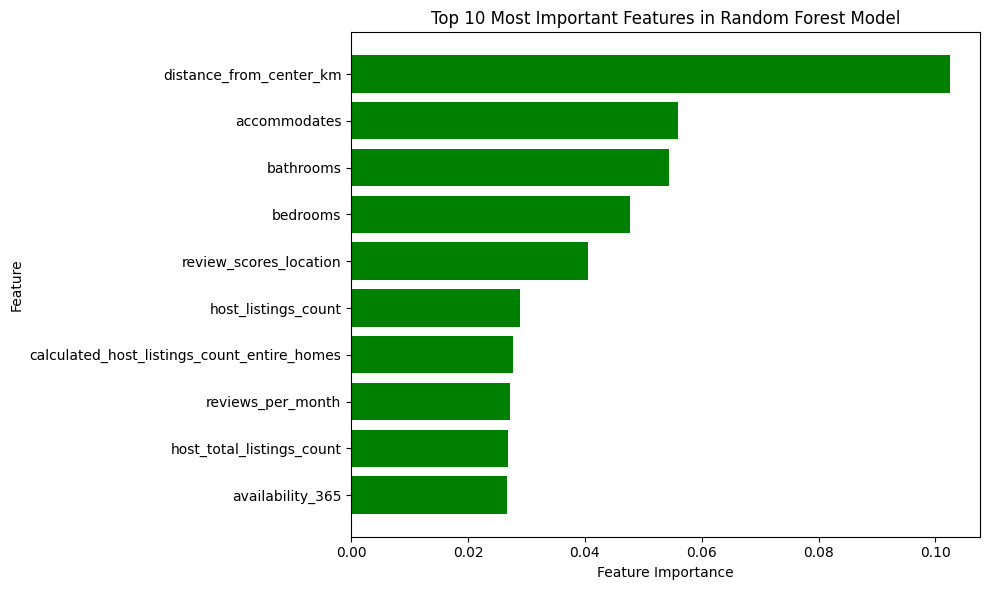

In [36]:
# Ensure rf_feature_importance is limited to top 10 features
top_10_features_rf = rf_feature_importance.head(10)

# Create a Horizontal Bar Plot for the Top 10 Features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_rf["Feature"], top_10_features_rf["Importance"], color="green")
plt.gca().invert_yaxis() 
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features in Random Forest Model")
plt.tight_layout() 
plt.show()

## **Feature Importance: XGBoost**

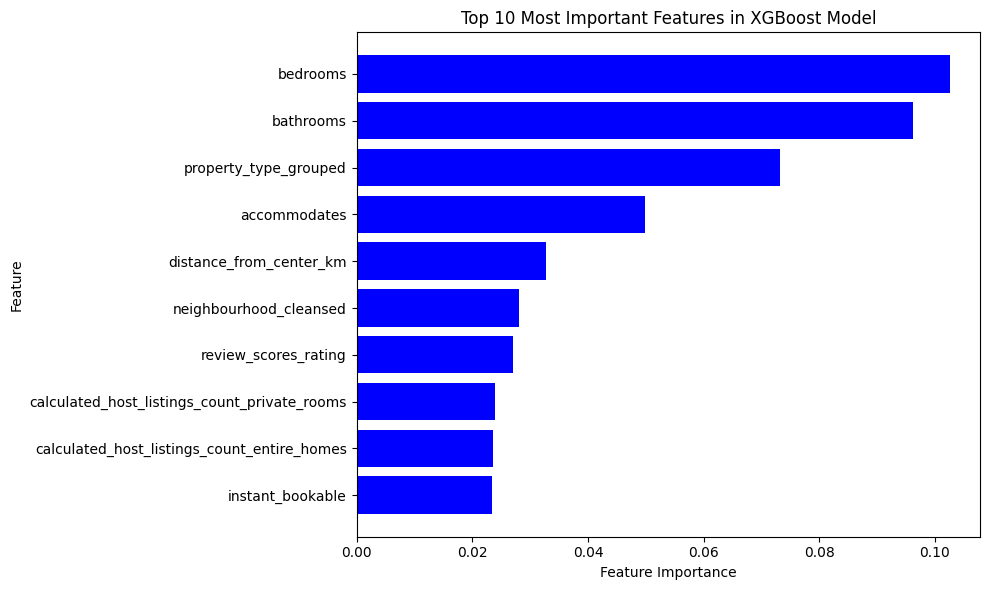

In [37]:
# Ensure feature_importance_xgb is limited to top 10 features
top_10_features_xgb = feature_importance_xgb.head(10)

# Plot Feature Importance for XGBoost
plt.figure(figsize=(10, 6))  
plt.barh(top_10_features_xgb["Feature"], top_10_features_xgb["Importance"], color="blue")
plt.gca().invert_yaxis()  
plt.xlabel("Feature Importance")  
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features in XGBoost Model")  
plt.tight_layout()
plt.show()


### **Key Insights**
- **Property attributes take priority**, with `bedrooms`, `bathrooms`, and `property_type_grouped` leading the model.
- **Location is still relevant but less dominant**, as `distance_from_center_km` ranks lower.
- **Guest preferences play a role**, with `instant_bookable`, `neighbourhood_cleansed`, and `review_scores_rating` appearing among the top 10.

---

## **Comparison: RF vs. XGBoost**
| Feature                         | **Random Forest Importance** | **XGBoost Importance** |
|----------------------------------|-----------------------------|-------------------------|
| **Distance from center**        | ✅ High                     | ⬆ Medium               |
| **Bedrooms**                    | ⬆ Medium                    | ✅ High                |
| **Bathrooms**                    | ⬆ Medium                    | ✅ High                |
| **Accommodates**                | ✅ High                     | ✅ High                |
| **Property type grouped**       | ❌ Not in Top 10            | ✅ High                |
| **Review scores (location)**    | ✅ High                     | ⬆ Medium               |
| **Host listings count**         | ✅ High                     | ❌ Not in Top 10       |
| **Availability 365**            | ✅ Medium                   | ❌ Not in Top 10       |
| **Instant Bookable**            | ❌ Not in Top 10            | ✅ Medium               |
| **Neighbourhood Cleansed**      | ❌ Not in Top 10            | ✅ Medium               |

---

## **Findings**
- **Random Forest emphasizes location-based pricing**, with `distance_from_center_km` being the strongest predictor.
- **XGBoost balances property characteristics and guest preferences**, suggesting a more nuanced price estimation.
- **Host-specific features (e.g., total listings) matter more in RF**, whereas **XGBoost gives weight to property type and booking preferences**.

---

## **Conclusion**
- **Random Forest** is **more interpretable**, making it useful when location-based trends are important.
- **XGBoost** is **more sophisticated**, capturing interactions between property characteristics and user preferences.
- If transparency is key → **Random Forest is a solid choice**  
- If accuracy is a priority → **XGBoost is the better model**

# **Validity – Testing on New Data**

 ### **Athens Q3**:  
   - Apply the **same data wrangling process** (feature engineering, handling missing values, encoding).
   - Test model performance to see if they maintain accuracy over time.

In [38]:
df_athens_q3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14137 entries, 0 to 14136
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            14137 non-null  int64  
 1   listing_url                                   14137 non-null  object 
 2   scrape_id                                     14137 non-null  int64  
 3   last_scraped                                  14137 non-null  object 
 4   source                                        14137 non-null  object 
 5   name                                          14137 non-null  object 
 6   description                                   13834 non-null  object 
 7   neighborhood_overview                         7758 non-null   object 
 8   picture_url                                   14137 non-null  object 
 9   host_id                                       14137 non-null 

In [39]:
# Define the center of Athens (Syntagma Square)
athens_center_coords = (37.9755, 23.7349)  # (latitude, longitude)
# Function to calculate distance from Athens center
def calculate_distance(row):
    listing_coords = (row['latitude'], row['longitude'])
    return geodesic(athens_center_coords, listing_coords).kilometers
# Create a new column for distance
df_athens_q3['distance_from_center_km'] = df_athens_q3.apply(calculate_distance, axis=1)


In [40]:
# Convert 'price' column to numeric
df_athens_q3['price'] = df_athens_q3['price'].replace('[\$,]', '', regex=True).astype(float)

# Fill missing numerical values with median to avoid data loss
df_athens_q3.fillna(df_athens_q3.median(numeric_only=True), inplace=True)


# Define boolean-like columns
bool_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']

# Convert boolean-like columns to 0/1
for col in bool_columns:
    df_athens_q3[col] = df_athens_q3[col].map({'t': 1, 'f': 0})


# Update list with additional amenities
top_amenities = [
    "Wifi", "TV", "Kitchen", "Heating", "AC", "Washer", "Dryer", "Elevator", 
    "Free parking", "Pool", "Gym", "Smoke detector", "Fire extinguisher", "Hot tub"
]

# Convert amenities into binary variables (0/1)
for amenity in top_amenities:
    df_athens_q3[f"d_{amenity.lower().replace(' ', '')}"] = df_athens_q3["amenities"].str.contains(amenity, na=False).astype(int)

In [41]:
# Columns to drop
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'host_since',
    'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_about', 'host_response_time', 
    'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'amenities', 'has_availability',
    'calendar_updated', 'calendar_last_scraped', 'license', 'neighbourhood_group_cleansed', 'host_acceptance_rate',
    'host_location', 'host_id', 'first_review', 'last_review', 'bathrooms_text', 'latitude','longitude', 'host_response_rate'  
]

# Drop only the columns that exist in the DataFrame
df_athens_q3 = df_athens_q3.drop(columns=[col for col in columns_to_drop if col in df_athens_q3.columns])

# Assuming df_athens_q3 is already loaded
df_athens_q3 = df_athens_q3.dropna(subset=['host_is_superhost'])



In [42]:
# How are extreme prices distributed?
df_athens_q3.price.quantile([0.75, 0.8, 0.9, 0.95, 0.99, 0.995]).map('{:,.2f}'.format)

0.750    115.00
0.800    130.00
0.900    185.00
0.950    262.00
0.990    522.00
0.995    711.83
Name: price, dtype: object

In [43]:
# We pick USD 270, above which all observations are excluded in the charts below.
df_athens_q3=df_athens_q3[df_athens_q3.price<270]

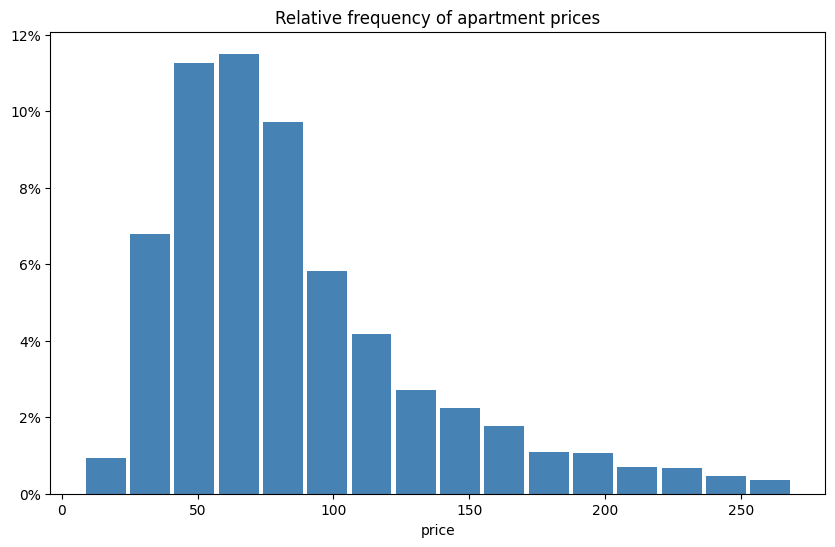

In [44]:
from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(df_athens_q3.price, bins = 16, density = True, rwidth = 0.9, color = 'steelblue')
ax.set_xlabel('price')
# ax.grid()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=0.1, decimals = 0))
ax.set_title('Relative frequency of apartment prices')
plt.show()

In [45]:

property_type_mapping = {
    "Entire rental unit": "Entire Apartment/Condo",
    "Entire condo": "Entire Apartment/Condo",
    "Entire home": "Entire Apartment/Condo",
    "Entire serviced apartment": "Entire Apartment/Condo",
    "Entire loft": "Entire Apartment/Condo",
    
    "Private room in rental unit": "Private Room",
    "Private room in condo": "Private Room",
    "Private room in serviced apartment": "Private Room",
    "Private room in home": "Private Room",
    "Private room in guesthouse": "Private Room",
    "Private room in townhouse": "Private Room",
    "Private room in hostel": "Private Room",
    "Private room in earthen home": "Private Room",
    "Private room in tent": "Private Room",
    "Private room in casa particular": "Private Room",
    "Private room in bed and breakfast": "Private Room",
    "Private room in guest suite": "Private Room",
    "Private room": "Private Room",
    
    "Room in hotel": "Hotel/Aparthotel",
    "Room in aparthotel": "Hotel/Aparthotel",
    "Room in boutique hotel": "Hotel/Aparthotel",
    "Room in serviced apartment": "Hotel/Aparthotel",
    "Shared room in hotel": "Hotel/Aparthotel",
    
    "Shared room in rental unit": "Shared Room",
    "Shared room in hostel": "Shared Room",
    "Shared room in guesthouse": "Shared Room",
    "Shared room in home": "Shared Room",
    "Shared room in bed and breakfast": "Shared Room",
    "Shared room in townhouse": "Shared Room",
    
    "Entire vacation home": "Luxury/Vacation Home",
    "Entire townhouse": "Luxury/Vacation Home",
    "Entire guesthouse": "Luxury/Vacation Home",
    "Entire guest suite": "Luxury/Vacation Home",
    "Entire villa": "Luxury/Vacation Home",
    "Tiny home": "Luxury/Vacation Home",
    "Cycladic home": "Luxury/Vacation Home",
    "Casa particular": "Luxury/Vacation Home",
    "Earthen home": "Luxury/Vacation Home",
    "Camper/RV": "Luxury/Vacation Home",
}

df_athens_q3.loc[:, "property_type_grouped"] = df_athens_q3["property_type"].map(property_type_mapping).fillna("Other")
# Drop the original property_type column
df_athens_q3.drop(columns=["property_type"], inplace=True)

In [46]:
# Count occurrences of each neighbourhood
neighbourhood_counts = df_athens_q3["neighbourhood_cleansed"].value_counts()

# Identify neighbourhoods with count < 50
small_neighbourhoods = neighbourhood_counts[neighbourhood_counts < 50].index

# Replace them with "Other"
df_athens_q3.loc[df_athens_q3["neighbourhood_cleansed"].isin(small_neighbourhoods), "neighbourhood_cleansed"] = "Other"

In [47]:
df_athens_q3.neighbourhood_cleansed.value_counts()

neighbourhood_cleansed
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              2284
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                 1067
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ             978
ΝΕΟΣ ΚΟΣΜΟΣ                          976
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ     876
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ                      537
ΠΑΓΚΡΑΤΙ                             513
ΑΜΠΕΛΟΚΗΠΟΙ                          438
ΚΟΛΩΝΑΚΙ                             397
ΑΚΡΟΠΟΛΗ                             350
ΠΕΤΡΑΛΩΝΑ                            348
ΚΕΡΑΜΕΙΚΟΣ                           345
ΘΗΣΕΙΟ                               342
ΚΥΨΕΛΗ                               274
ΓΟΥΔΙ                                229
ΙΛΙΣΙΑ                               215
ΣΤΑΔΙΟ                               194
ΝΙΡΒΑΝΑ                              174
ΠΑΤΗΣΙΑ                              170
ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ                     168
Other                                148
ΛΥΚΑΒΗΤΤΟΣ                           147
ΖΑΠΠΕΙΟ                              145
ΑΝΩ ΚΥΨΕΛΗ                        

In [48]:
df_athens_q3.property_type_grouped.value_counts()

property_type_grouped
Entire Apartment/Condo    11445
Private Room                641
Hotel/Aparthotel            348
Luxury/Vacation Home         86
Shared Room                  48
Other                        13
Name: count, dtype: int64

In [49]:
df_athens_q3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12581 entries, 0 to 14136
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_is_superhost                             12581 non-null  float64
 1   host_listings_count                           12581 non-null  int64  
 2   host_total_listings_count                     12581 non-null  int64  
 3   host_verifications                            12581 non-null  object 
 4   host_has_profile_pic                          12581 non-null  int64  
 5   host_identity_verified                        12581 non-null  int64  
 6   neighbourhood_cleansed                        12581 non-null  object 
 7   room_type                                     12581 non-null  object 
 8   accommodates                                  12581 non-null  int64  
 9   bathrooms                                     12581 non-null  floa

In [50]:
reg5_1 = smf.ols(
    "price ~ distance_from_center_km + accommodates + property_type_grouped + review_scores_rating +host_is_superhost + availability_365",
    data = df_athens_q3,
).fit(cov_type="HC0")
print(reg5_1.get_robustcov_results(cov_type='HC1').summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     496.3
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:37:36   Log-Likelihood:                -64113.
No. Observations:               12581   AIC:                         1.282e+05
Df Residuals:                   12570   BIC:                         1.283e+05
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [51]:
# Extract R² (R-squared)
r2_ols5_1 = reg5_1.rsquared

# Extract RMSE (Root Mean Squared Error)
rmse_ols5_1 = np.sqrt(reg5_1.mse_resid)

# Store in a dictionary
ols_metrics2 = {
    "OLS (reg5_1)": {
        "RMSE": round(rmse_ols5_1, 2),
        "R²": round(r2_ols5_1, 3)
    }
}

print(ols_metrics2)

{'OLS (reg5_1)': {'RMSE': 39.55, 'R²': 0.324}}


In [52]:
# Load new dataset
df_new = df_athens_q3.copy()


# Preprocess: Convert price and drop NaNs
df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce")
df_new = df_new.dropna(subset=["price"])

# Apply the same feature engineering as training
y_new, X_new = patsy.dmatrices("price " + modellev8, df_new)

# Scale features using the trained scaler (assumed to be in memory from training)
X_new = scaler.transform(X_new)  # Assumes scaler is already fitted

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_lasso_1_scores = []
r2_lasso_1_scores = []

for train_index, test_index in kf.split(X_new):
    X_cv_train, X_cv_test = X_new[train_index], X_new[test_index]
    y_cv_train, y_cv_test = y_new[train_index], y_new[test_index]
    
    # Predict with the trained lasso_model (assumed to be in memory)
    y_pred_cv = lasso_model.predict(X_cv_test)
    
    # Calculate metrics
    rmse_lasso_1_scores.append(mean_squared_error(y_cv_test, y_pred_cv, squared=False))
    r2_lasso_1_scores.append(r2_score(y_cv_test, y_pred_cv))

# Compute mean and standard deviation
mean_rmse_lasso_1 = np.mean(rmse_lasso_1_scores)
std_rmse_lasso_1 = np.std(rmse_lasso_1_scores)
mean_r2_lasso_1 = np.mean(r2_lasso_1_scores)
std_r2_lasso_1 = np.std(r2_lasso_1_scores)

# Print results
print("Lasso Model Cross-Validation Results (Athens Q3) - Model 1")
print(f"Mean RMSE (rmse_lasso_1): {mean_rmse_lasso_1:.2f} (± {std_rmse_lasso_1:.2f})")
print(f"Mean R² (r2_lasso_1): {mean_r2_lasso_1:.3f} (± {std_r2_lasso_1:.3f})")

Lasso Model Cross-Validation Results (Athens Q3) - Model 1
Mean RMSE (rmse_lasso_1): 38.27 (± 0.41)
Mean R² (r2_lasso_1): 0.365 (± 0.017)


In [53]:
# Load new dataset
df_new = df_athens_q3.copy()

# Ensure 'price' isn't accidentally dropped
df_new = df_new.drop(columns=[col for col in columns_to_drop if col in df_new.columns and col != 'price'], errors="ignore")

# Convert "price" to numeric
df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce").fillna(0)

# One-hot encode categorical columns
non_numeric_cols_new = df_new.select_dtypes(include=["object"]).columns.tolist()
non_numeric_cols_new = [col for col in non_numeric_cols_new if col != "price"]
df_new = pd.get_dummies(df_new, columns=non_numeric_cols_new, drop_first=True)

# Find missing and extra columns compared to training data
missing_cols = [col for col in rf_feature_names_memory if col not in df_new.columns]
extra_cols = [col for col in df_new.columns if col not in rf_feature_names_memory and col != "price"]

# Add missing columns as 0
for col in missing_cols:
    df_new[col] = 0

# Drop extra columns (except 'price')
df_new = df_new.drop(columns=extra_cols, errors="ignore")

# Ensure column order matches training data
X_new = df_new[rf_feature_names_memory]
y_new = df_new["price"]

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_rf_1_scores = []
r2_rf_1_scores = []

for train_index, test_index in kf.split(X_new):
    # Split data
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train, y_test = y_new.iloc[train_index], y_new.iloc[test_index]
    
    # Make predictions (using the in-memory model)
    y_pred = rf_model_memory.predict(X_test)
    
    # Calculate metrics
    rmse_rf_1 = mean_squared_error(y_test, y_pred, squared=False)
    r2_rf_1 = r2_score(y_test, y_pred)
    
    rmse_rf_1_scores.append(rmse_rf_1)
    r2_rf_1_scores.append(r2_rf_1)

# Compute mean and standard deviation for metrics
mean_rmse_rf_1 = np.mean(rmse_rf_1_scores)
std_rmse_rf_1 = np.std(rmse_rf_1_scores)
mean_r2_rf_1 = np.mean(r2_rf_1_scores)
std_r2_rf_1 = np.std(r2_rf_1_scores)

# Print cross-validation results
print("\nRandom Forest Model Cross-Validation Results")
print(f"Mean RMSE (rmse_rf_1): {mean_rmse_rf_1:.2f} (± {std_rmse_rf_1:.2f})")
print(f"Mean R² (r2_rf_1): {mean_r2_rf_1:.3f} (± {std_r2_rf_1:.3f})")



Random Forest Model Cross-Validation Results
Mean RMSE (rmse_rf_1): 28.23 (± 0.60)
Mean R² (r2_rf_1): 0.655 (± 0.008)


In [54]:
# Ensure the trained XGBoost model and feature names exist in memory
if "xgb_model_memory" not in globals() or "xgb_feature_names_memory" not in globals():
    raise ValueError("XGBoost model and feature names must be stored in memory before running validation.")

# Load new dataset
df_new = df_athens_q3.copy()

# Ensure 'price' isn't accidentally dropped
df_new = df_new.drop(columns=[col for col in columns_to_drop if col in df_new.columns and col != 'price'], errors="ignore")

# Convert "price" to numeric
df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce").fillna(0)

# Convert categorical variables to category dtype
for col in categorical_features:
    if col in df_new.columns:
        df_new[col] = df_new[col].astype("category")

# Find missing and extra columns compared to training data
missing_cols = [col for col in xgb_feature_names_memory if col not in df_new.columns]
extra_cols = [col for col in df_new.columns if col not in xgb_feature_names_memory and col != "price"]

# Add missing columns as 0
for col in missing_cols:
    df_new[col] = 0

# Drop extra columns (except 'price')
df_new = df_new.drop(columns=extra_cols, errors="ignore")

# Separate target and features
y_new = df_new["price"]
X_new = df_new[xgb_feature_names_memory]  # Reorder columns for consistency

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_xgb_1_scores = []
r2_xgb_1_scores = []

for train_index, test_index in kf.split(X_new):
    # Correctly slice X_new and y_new for train/test
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train, y_test = y_new.iloc[train_index], y_new.iloc[test_index]
    
    # Ensure exact feature order before prediction
    X_test = X_test[xgb_feature_names_memory]

    # Make predictions (disable feature validation to avoid mismatch error)
    y_pred = xgb_model_memory.predict(X_test, validate_features=False)
    
    # Calculate metrics
    rmse_xgb_1 = mean_squared_error(y_test, y_pred, squared=False)
    r2_xgb_1 = r2_score(y_test, y_pred)
    
    rmse_xgb_1_scores.append(rmse_xgb_1)
    r2_xgb_1_scores.append(r2_xgb_1)

# Compute mean and standard deviation for metrics
mean_rmse_xgb_1 = np.mean(rmse_xgb_1_scores)
std_rmse_xgb_1 = np.std(rmse_xgb_1_scores)
mean_r2_xgb_1 = np.mean(r2_xgb_1_scores)
std_r2_xgb_1 = np.std(r2_xgb_1_scores)

# Print cross-validation results
print("\nXGBoost Model Cross-Validation Results")
print(f"Mean RMSE (rmse_xgb_1): {mean_rmse_xgb_1:.2f} (± {std_rmse_xgb_1:.2f})")
print(f"Mean R² (r2_xgb_1): {mean_r2_xgb_1:.3f} (± {std_r2_xgb_1:.3f})")



XGBoost Model Cross-Validation Results
Mean RMSE (rmse_xgb_1): 27.99 (± 0.51)
Mean R² (r2_xgb_1): 0.661 (± 0.012)


In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Ensure the trained LightGBM model and feature names exist in memory
if "lgb_model_memory" not in globals():
    raise ValueError("LightGBM model must be stored in memory before running validation.")

# Load new dataset
df_new = df_athens_q3.copy()

# Ensure 'price' isn't accidentally dropped
df_new = df_new.drop(columns=[col for col in columns_to_drop if col in df_new.columns and col != 'price'], errors="ignore")

# Convert "price" to numeric and drop missing values
df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce")
df_new = df_new.dropna(subset=["price"])

# One-hot encode categorical variables
df_new = pd.get_dummies(df_new, columns=categorical_features, drop_first=True)

# Use the model's feature names instead of relying on lgb_feature_names_memory
expected_feature_names = lgb_model_memory.feature_name()
expected_feature_count = len(expected_feature_names)

# Find missing and extra columns compared to training data
missing_cols = [col for col in expected_feature_names if col not in df_new.columns]
extra_cols = [col for col in df_new.columns if col not in expected_feature_names and col != "price"]

# Add missing columns as 0
for col in missing_cols:
    df_new[col] = 0

# Drop extra columns (except 'price')
df_new = df_new.drop(columns=extra_cols, errors="ignore")

# Separate features and target, ensure exact feature match
y_new = df_new["price"].reset_index(drop=True)
X_new = df_new[expected_feature_names].reset_index(drop=True)  # Use model's feature names

# Debugging: Verify feature count
if X_new.shape[1] != expected_feature_count:
    raise ValueError(f"Feature count mismatch: X_new has {X_new.shape[1]} features, expected {expected_feature_count}")

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_lgb_1_scores = []
r2_lgb_1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_new)):
    # Split data
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train, y_test = y_new.iloc[train_index], y_new.iloc[test_index]
    
    # Ensure exact feature order before prediction
    X_test = X_test[expected_feature_names]

    # Make predictions using the stored LightGBM model
    y_pred = lgb_model_memory.predict(X_test, num_iteration=lgb_model_memory.best_iteration)

    # Calculate metrics
    rmse_lgb_1 = mean_squared_error(y_test, y_pred, squared=False)
    r2_lgb_1 = r2_score(y_test, y_pred)
    
    rmse_lgb_1_scores.append(rmse_lgb_1)
    r2_lgb_1_scores.append(r2_lgb_1)

# Compute mean and standard deviation for metrics
mean_rmse_lgb_1 = np.mean(rmse_lgb_1_scores)
std_rmse_lgb_1 = np.std(rmse_lgb_1_scores)
mean_r2_lgb_1 = np.mean(r2_lgb_1_scores)
std_r2_lgb_1 = np.std(r2_lgb_1_scores)

# Print cross-validation results
print(f"Mean RMSE (rmse_lgb_1): {mean_rmse_lgb_1:.2f} (± {std_rmse_lgb_1:.2f})")
print(f"Mean R² (r2_lgb_1): {mean_r2_lgb_1:.3f} (± {std_r2_lgb_1:.3f})")

Mean RMSE (rmse_lgb_1): 29.03 (± 0.48)
Mean R² (r2_lgb_1): 0.635 (± 0.005)


 ### **Naples Q3**:  
   - Apply the same **preprocessing pipeline** as before.
   - Evaluate if our pricing model generalizes well to new locations.

In [56]:
df_naples_q3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10760 entries, 0 to 10759
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10760 non-null  int64  
 1   listing_url                                   10760 non-null  object 
 2   scrape_id                                     10760 non-null  int64  
 3   last_scraped                                  10760 non-null  object 
 4   source                                        10760 non-null  object 
 5   name                                          10760 non-null  object 
 6   description                                   10467 non-null  object 
 7   neighborhood_overview                         5664 non-null   object 
 8   picture_url                                   10760 non-null  object 
 9   host_id                                       10760 non-null 

In [57]:
# Define the center of Naples (Piazza del Plebiscito)
naples_center_coords = (40.8359, 14.2488)  # (latitude, longitude)

# Function to calculate distance from Naples city center
def calculate_distance(row):
    listing_coords = (row['latitude'], row['longitude'])
    return geodesic(naples_center_coords, listing_coords).kilometers

# Create a new column for distance
df_naples_q3['distance_from_center_km'] = df_naples_q3.apply(calculate_distance, axis=1)


In [58]:
# Convert 'price' column to numeric
df_naples_q3['price'] = df_naples_q3['price'].replace('[\$,]', '', regex=True).astype(float)

# Fill missing numerical values with median to avoid data loss
df_naples_q3.fillna(df_naples_q3.median(numeric_only=True), inplace=True)


# Define boolean-like columns
bool_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']

# Convert boolean-like columns to 0/1
for col in bool_columns:
    df_naples_q3[col] = df_naples_q3[col].map({'t': 1, 'f': 0})


# Update list with additional amenities
top_amenities = [
    "Wifi", "TV", "Kitchen", "Heating", "AC", "Washer", "Dryer", "Elevator", 
    "Free parking", "Pool", "Gym", "Smoke detector", "Fire extinguisher", "Hot tub"
]

# Convert amenities into binary variables (0/1)
for amenity in top_amenities:
    df_naples_q3[f"d_{amenity.lower().replace(' ', '')}"] = df_naples_q3["amenities"].str.contains(amenity, na=False).astype(int)

In [59]:
# Columns to drop
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'host_since',
    'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_about', 'host_response_time', 
    'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'amenities', 'has_availability',
    'calendar_updated', 'calendar_last_scraped', 'license', 'neighbourhood_group_cleansed', 'host_acceptance_rate',
    'host_location', 'host_id', 'first_review', 'last_review', 'bathrooms_text', 'latitude','longitude', 'host_response_rate'  
]

# Drop only the columns that exist in the DataFrame
df_naples_q3 = df_naples_q3.drop(columns=[col for col in columns_to_drop if col in df_naples_q3.columns])

# Assuming df_naples_q3 is already loaded
df_naples_q3 = df_naples_q3.dropna(subset=['host_is_superhost'])

In [60]:
# How are extreme prices distributed?
df_naples_q3.price.quantile([0.75, 0.8, 0.9, 0.95, 0.99, 0.995]).map('{:,.2f}'.format)

0.750    121.00
0.800    135.00
0.900    180.00
0.950    240.00
0.990    500.00
0.995    800.00
Name: price, dtype: object

In [61]:
# We pick USD 270, above which all observations are excluded in the charts below.
df_naples_q3=df_naples_q3[df_naples_q3.price<270]

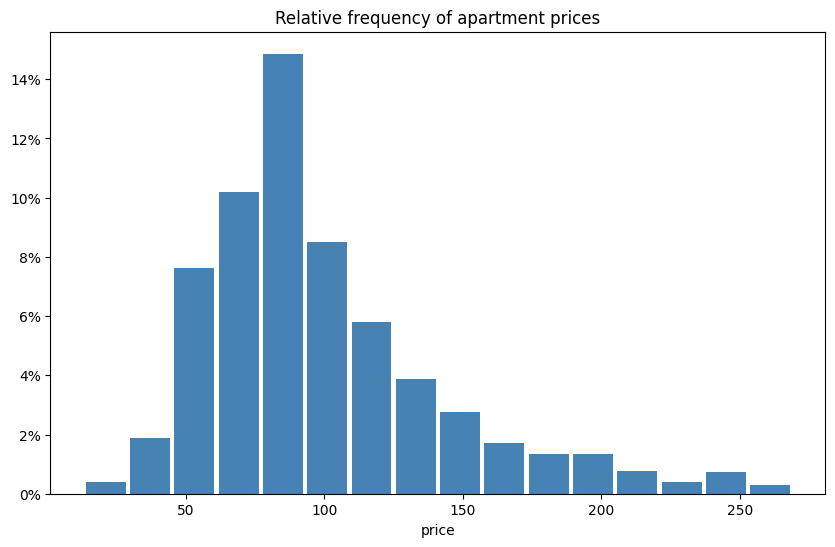

In [62]:
# relative frequencies with matplotlib

from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(df_naples_q3.price, bins = 16, density = True, rwidth = 0.9, color = 'steelblue')
ax.set_xlabel('price')
# ax.grid()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=0.1, decimals = 0))
ax.set_title('Relative frequency of apartment prices')
plt.show()

In [63]:
df_naples_q3.property_type.value_counts()

property_type
Entire rental unit                    3743
Private room in bed and breakfast     1527
Entire condo                          1232
Private room in rental unit            996
Entire home                            889
Entire vacation home                   413
Private room in condo                  307
Private room in home                   135
Entire loft                            110
Room in bed and breakfast               93
Tiny home                               92
Room in boutique hotel                  89
Private room in vacation home           58
Private room in serviced apartment      47
Entire serviced apartment               44
Room in hotel                           28
Shared room in rental unit              26
Private room in guest suite             23
Private room in guesthouse              20
Shared room in bed and breakfast        20
Entire guest suite                      19
Room in serviced apartment              16
Shared room in hostel                   

In [64]:
# Define the property type mapping for Naples
property_type_mapping_naples = {
    "Entire rental unit": "Entire Apartment/Condo",
    "Entire condo": "Entire Apartment/Condo",
    "Entire home": "Entire Apartment/Condo",
    "Entire serviced apartment": "Entire Apartment/Condo",
    "Entire loft": "Entire Apartment/Condo",

    "Private room in rental unit": "Private Room",
    "Private room in condo": "Private Room",
    "Private room in serviced apartment": "Private Room",
    "Private room in home": "Private Room",
    "Private room in guesthouse": "Private Room",
    "Private room in townhouse": "Private Room",
    "Private room in hostel": "Private Room",
    "Private room in earthen home": "Private Room",
    "Private room in tent": "Private Room",
    "Private room in casa particular": "Private Room",
    "Private room in bed and breakfast": "Private Room",
    "Private room in guest suite": "Private Room",
    "Private room": "Private Room",

    "Room in hotel": "Hotel/Aparthotel",
    "Room in aparthotel": "Hotel/Aparthotel",
    "Room in boutique hotel": "Hotel/Aparthotel",
    "Room in serviced apartment": "Hotel/Aparthotel",
    "Shared room in hotel": "Hotel/Aparthotel",

    "Shared room in rental unit": "Shared Room",
    "Shared room in hostel": "Shared Room",
    "Shared room in guesthouse": "Shared Room",
    "Shared room in home": "Shared Room",
    "Shared room in bed and breakfast": "Shared Room",
    "Shared room in townhouse": "Shared Room",

    "Entire vacation home": "Luxury/Vacation Home",
    "Entire townhouse": "Luxury/Vacation Home",
    "Entire guesthouse": "Luxury/Vacation Home",
    "Entire guest suite": "Luxury/Vacation Home",
    "Entire villa": "Luxury/Vacation Home",
    "Tiny home": "Luxury/Vacation Home",
    "Cycladic home": "Luxury/Vacation Home",
    "Casa particular": "Luxury/Vacation Home",
    "Earthen home": "Luxury/Vacation Home",
    "Camper/RV": "Luxury/Vacation Home",
}

# Apply the property type mapping to Naples dataset
df_naples_q3["property_type_grouped"] = df_naples_q3["property_type"].map(property_type_mapping_naples).fillna("Other")

# Drop the original property_type column
df_naples_q3.drop(columns=["property_type"], inplace=True)



In [65]:
# Display the grouped counts
df_naples_q3["property_type_grouped"].value_counts()

property_type_grouped
Entire Apartment/Condo    6018
Private Room              3083
Luxury/Vacation Home       556
Other                      189
Hotel/Aparthotel           136
Shared Room                 64
Name: count, dtype: int64

In [66]:
# Count occurrences of each neighbourhood
neighbourhood_counts = df_naples_q3["neighbourhood_cleansed"].value_counts()

# Identify neighbourhoods with count < 50
small_neighbourhoods = neighbourhood_counts[neighbourhood_counts < 50].index

# Replace them with "Other"
df_naples_q3.loc[df_naples_q3["neighbourhood_cleansed"].isin(small_neighbourhoods), "neighbourhood_cleansed"] = "Other"

In [67]:
df_naples_q3.neighbourhood_cleansed.value_counts()

neighbourhood_cleansed
San Lorenzo            1824
Pendino                 957
San Ferdinando          870
Montecalvario           784
Chiaia                  754
Avvocata                655
San Giuseppe            586
Stella                  552
Porto                   551
San Carlo all'Arena     482
Vomero                  435
Vicaria                 288
Other                   228
Arenella                212
Mercato                 201
Fuorigrotta             183
Zona Industriale        163
Posillipo               156
Poggioreale              87
Bagnoli                  78
Name: count, dtype: int64

In [68]:
df_naples_q3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10046 entries, 0 to 10759
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_is_superhost                             10046 non-null  float64
 1   host_listings_count                           10046 non-null  int64  
 2   host_total_listings_count                     10046 non-null  int64  
 3   host_verifications                            10046 non-null  object 
 4   host_has_profile_pic                          10046 non-null  int64  
 5   host_identity_verified                        10046 non-null  int64  
 6   neighbourhood_cleansed                        10046 non-null  object 
 7   room_type                                     10046 non-null  object 
 8   accommodates                                  10046 non-null  int64  
 9   bathrooms                                     10046 non-null  floa

In [69]:
reg5_2 = smf.ols(
    "price ~ distance_from_center_km + accommodates + property_type_grouped + review_scores_rating +host_is_superhost + availability_365",
    data = df_naples_q3,
).fit(cov_type="HC0")
print(reg5_2.get_robustcov_results(cov_type='HC1').summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     125.0
Date:                Sun, 02 Mar 2025   Prob (F-statistic):          5.26e-247
Time:                        23:37:39   Log-Likelihood:                -51301.
No. Observations:               10046   AIC:                         1.026e+05
Df Residuals:                   10035   BIC:                         1.027e+05
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [70]:
# Extract R² (R-squared)
r2_ols5_2 = reg5_2.rsquared

# Extract RMSE (Root Mean Squared Error)
rmse_ols5_2 = np.sqrt(reg5_2.mse_resid)

# Store in a dictionary
ols_metrics3 = {
    "OLS (reg5_1)": {
        "RMSE": round(rmse_ols5_2, 2),
        "R²": round(r2_ols5_2, 3)
    }
}

print(ols_metrics3)

{'OLS (reg5_1)': {'RMSE': 39.97, 'R²': 0.168}}


In [71]:
# Load new dataset
df_new = df_naples_q3.copy()

# Preprocess: Convert price and drop NaNs
df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce")
df_new = df_new.dropna(subset=["price"])

# Apply the same feature engineering as training
y_new, X_new = patsy.dmatrices("price " + modellev8, df_new)

# Scale features using the trained scaler (assumed to be in memory from training)
X_new = scaler.transform(X_new)  # Assumes scaler is already fitted

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_lasso_2_scores = []
r2_lasso_2_scores = []

for train_index, test_index in kf.split(X_new):
    X_cv_train, X_cv_test = X_new[train_index], X_new[test_index]
    y_cv_train, y_cv_test = y_new[train_index], y_new[test_index]
    
    # Predict with the trained lasso_model (assumed to be in memory)
    y_pred_cv = lasso_model.predict(X_cv_test)
    
    # Calculate metrics
    rmse_lasso_2_scores.append(mean_squared_error(y_cv_test, y_pred_cv, squared=False))
    r2_lasso_2_scores.append(r2_score(y_cv_test, y_pred_cv))

# Compute mean and standard deviation
mean_rmse_lasso_2 = np.mean(rmse_lasso_2_scores)
std_rmse_lasso_2 = np.std(rmse_lasso_2_scores)
mean_r2_lasso_2 = np.mean(r2_lasso_2_scores)
std_r2_lasso_2 = np.std(r2_lasso_2_scores)

# Print results
print("Lasso Model Cross-Validation Results (Naples Q3) - Model 2")
print(f"Mean RMSE (rmse_lasso_2): {mean_rmse_lasso_2:.2f} (± {std_rmse_lasso_2:.2f})")
print(f"Mean R² (r2_lasso_2): {mean_r2_lasso_2:.3f} (± {std_r2_lasso_2:.3f})")

Lasso Model Cross-Validation Results (Naples Q3) - Model 2
Mean RMSE (rmse_lasso_2): 46.33 (± 0.98)
Mean R² (r2_lasso_2): -0.121 (± 0.039)


In [72]:
# Ensure the trained Random Forest model and feature names exist in memory
if "rf_model_memory" not in globals() or "rf_feature_names_memory" not in globals():
    raise ValueError("Random Forest model and feature names must be stored in memory before running validation.")

# Load new Naples dataset
df_new = df_naples_q3.copy()  # Renamed df_naples_new to df_new for consistency

# Ensure 'price' isn’t accidentally dropped
df_new = df_new.drop(columns=[col for col in columns_to_drop if col in df_new.columns and col != 'price'], errors="ignore")

# Convert "price" to numeric and drop missing values
df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce")
df_new = df_new.dropna(subset=["price"])  # Drop NaN prices instead of filling with 0

# One-hot encode categorical columns
non_numeric_cols = [col for col in df_new.select_dtypes(include=["object"]).columns if col != "price"]
df_new = pd.get_dummies(df_new, columns=non_numeric_cols, drop_first=True)

# Find missing and extra columns compared to training data
missing_cols = [col for col in rf_feature_names_memory if col not in df_new.columns]
extra_cols = [col for col in df_new.columns if col not in rf_feature_names_memory and col != "price"]

# Add missing columns as 0
for col in missing_cols:
    df_new[col] = 0

# Drop extra columns (except 'price')
df_new = df_new.drop(columns=extra_cols, errors="ignore")

# Separate features and target, ensure exact feature match
y_new = df_new["price"].reset_index(drop=True)
X_new = df_new[rf_feature_names_memory].reset_index(drop=True) 

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_rf_2_scores = []
r2_rf_2_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_new)):
    # Split data
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train, y_test = y_new.iloc[train_index], y_new.iloc[test_index]
    
    # Make predictions using the stored Random Forest model
    y_pred = rf_model_memory.predict(X_test)

    # Calculate metrics
    rmse_rf_2 = mean_squared_error(y_test, y_pred, squared=False)
    r2_rf_2 = r2_score(y_test, y_pred)
    
    rmse_rf_2_scores.append(rmse_rf_2)
    r2_rf_2_scores.append(r2_rf_2)

# Compute mean and standard deviation for metrics
mean_rmse_rf_2 = np.mean(rmse_rf_2_scores)
std_rmse_rf_2 = np.std(rmse_rf_2_scores)
mean_r2_rf_2 = np.mean(r2_rf_2_scores)
std_r2_rf_2 = np.std(r2_rf_2_scores)

# Print cross-validation results
print("\nRandom Forest Model Cross-Validation Results (Naples Q3)")
print(f"Mean RMSE (rmse_rf_2): {mean_rmse_rf_2:.2f} (± {std_rmse_rf_2:.2f})")
print(f"Mean R² (r2_rf_2): {mean_r2_rf_2:.3f} (± {std_r2_rf_2:.3f})")


Random Forest Model Cross-Validation Results (Naples Q3)
Mean RMSE (rmse_rf_2): 41.41 (± 0.72)
Mean R² (r2_rf_2): 0.105 (± 0.023)


In [73]:
# Ensure the trained XGBoost model and feature names exist in memory
if "xgb_model_memory" not in globals() or "xgb_feature_names_memory" not in globals():
    raise ValueError("XGBoost model and feature names must be stored in memory before running validation.")

# Load new Naples dataset
df_new = df_naples_q3.copy()

# Ensure 'price' isn't accidentally dropped
df_new = df_new.drop(columns=[col for col in columns_to_drop if col in df_new.columns and col != 'price'], errors="ignore")

# Convert "price" to numeric and handle missing values
df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce")
df_new = df_new.dropna(subset=["price"])  # Drop NaN prices instead of filling with 0

# Convert categorical variables to category dtype
for col in categorical_features:
    if col in df_new.columns:
        df_new[col] = df_new[col].astype("category")
    else:
        print(f"Warning: Categorical feature '{col}' not in Naples Q3 dataset.")

# Find missing and extra columns compared to training data
missing_cols = [col for col in xgb_feature_names_memory if col not in df_new.columns]
extra_cols = [col for col in df_new.columns if col not in xgb_feature_names_memory and col != "price"]

# Add missing columns as 0
for col in missing_cols:
    df_new[col] = 0

# Drop extra columns (except 'price')
df_new = df_new.drop(columns=extra_cols, errors="ignore")

# Separate target and features, reset indices for alignment
y_new = df_new["price"].reset_index(drop=True)
X_new = df_new[xgb_feature_names_memory].reset_index(drop=True) 

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_xgb_2_scores = []
r2_xgb_2_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_new)):
    # Correctly slice X_new and y_new for train/test
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train, y_test = y_new.iloc[train_index], y_new.iloc[test_index]
    
    # Ensure exact feature order before prediction
    X_test = X_test[xgb_feature_names_memory]

    # Make predictions (disable feature validation to avoid mismatch error)
    y_pred = xgb_model_memory.predict(X_test, validate_features=False)

    # Calculate metrics
    rmse_xgb_2 = mean_squared_error(y_test, y_pred, squared=False)
    r2_xgb_2 = r2_score(y_test, y_pred)
    
    rmse_xgb_2_scores.append(rmse_xgb_2)
    r2_xgb_2_scores.append(r2_xgb_2)

# Compute mean and standard deviation for metrics
mean_rmse_xgb_2 = np.mean(rmse_xgb_2_scores)
std_rmse_xgb_2 = np.std(rmse_xgb_2_scores)
mean_r2_xgb_2 = np.mean(r2_xgb_2_scores)
std_r2_xgb_2 = np.std(r2_xgb_2_scores)

# Print cross-validation results
print("\nXGBoost Model Cross-Validation Results (Naples Q3)")
print(f"Mean RMSE (rmse_xgb_2): {mean_rmse_xgb_2:.2f} (± {std_rmse_xgb_2:.2f})")
print(f"Mean R² (r2_xgb_2): {mean_r2_xgb_2:.3f} (± {std_r2_xgb_2:.3f})")


XGBoost Model Cross-Validation Results (Naples Q3)
Mean RMSE (rmse_xgb_2): 40.88 (± 0.86)
Mean R² (r2_xgb_2): 0.128 (± 0.029)


In [74]:
# Ensure the trained LightGBM model exists in memory
if "lgb_model_memory" not in globals():
    raise ValueError("LightGBM model must be stored in memory before running validation.")

# Load new Naples dataset
df_new = df_naples_q3.copy()

# Ensure 'price' isn't accidentally dropped
df_new = df_new.drop(columns=[col for col in columns_to_drop if col in df_new.columns and col != 'price'], errors="ignore")

# Convert "price" to numeric and drop missing values
df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce")
df_new = df_new.dropna(subset=["price"])  # Drop NaN prices

# One-hot encode categorical variables
df_new = pd.get_dummies(df_new, columns=categorical_features, drop_first=True)

# Use the model's feature names
expected_feature_names = lgb_model_memory.feature_name()
expected_feature_count = len(expected_feature_names)

# Find missing and extra columns compared to training data
missing_cols = [col for col in expected_feature_names if col not in df_new.columns]
extra_cols = [col for col in df_new.columns if col not in expected_feature_names and col != "price"]

# Add missing columns as 0
for col in missing_cols:
    df_new[col] = 0

# Drop extra columns (except 'price')
df_new = df_new.drop(columns=extra_cols, errors="ignore")

# Separate features and target, ensure exact feature match
y_new = df_new["price"].reset_index(drop=True)
X_new = df_new[expected_feature_names].reset_index(drop=True) 


# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_lgb_2_scores = []
r2_lgb_2_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_new)):
    # Split data
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train, y_test = y_new.iloc[train_index], y_new.iloc[test_index]
    
    # Ensure exact feature order before prediction
    X_test = X_test[expected_feature_names]

    # Make predictions using the stored LightGBM model
    y_pred = lgb_model_memory.predict(X_test, num_iteration=lgb_model_memory.best_iteration)

    # Calculate metrics
    rmse_lgb_2 = mean_squared_error(y_test, y_pred, squared=False)
    r2_lgb_2 = r2_score(y_test, y_pred)
    
    rmse_lgb_2_scores.append(rmse_lgb_2)
    r2_lgb_2_scores.append(r2_lgb_2)

# Compute mean and standard deviation for metrics
mean_rmse_lgb_2 = np.mean(rmse_lgb_2_scores)
std_rmse_lgb_2 = np.std(rmse_lgb_2_scores)
mean_r2_lgb_2 = np.mean(r2_lgb_2_scores)
std_r2_lgb_2 = np.std(r2_lgb_2_scores)

# Print cross-validation results
print("\nLightGBM Model Cross-Validation Results (Naples Q3)")
print(f"Mean RMSE (rmse_lgb_2): {mean_rmse_lgb_2:.2f} (± {std_rmse_lgb_2:.2f})")
print(f"Mean R² (r2_lgb_2): {mean_r2_lgb_2:.3f} (± {std_r2_lgb_2:.3f})")


LightGBM Model Cross-Validation Results (Naples Q3)
Mean RMSE (rmse_lgb_2): 41.45 (± 0.86)
Mean R² (r2_lgb_2): 0.103 (± 0.029)


#  **Final Model Evaluation: Performance Across Datasets**

## **Objective**
Now that we have tested our models on different datasets (**Athens Q2, Athens Q3, and Naples Q3**), let's evaluate their **real-world performance** by comparing accuracy and stability.

In [75]:
# Example model_results dictionary (use your own actual values)
model_results = {
    "OLS (reg5)": {
        "Athens Q2": {"RMSE": rmse_ols5, "R²": r2_ols5, "time(s)": training_time_reg5},
        "Athens Q3": {"RMSE": rmse_ols5_1, "R²": r2_ols5_1, "time(s)": None},
        "Naples Q3": {"RMSE": rmse_ols5_2, "R²": r2_ols5_2, "time(s)": None},
    },
    "Lasso": {
        "Athens Q2": {"RMSE": rmse_lasso_train, "R²": r2_lasso_train, "time(s)": lambda_training_time},
        "Athens Q3": {"RMSE": mean_rmse_lasso_1, "R²": mean_r2_lasso_1, "time(s)": None},
        "Naples Q3": {"RMSE": mean_rmse_lasso_2, "R²": mean_r2_lasso_2, "time(s)": None},
    },
    "Random Forest": {
        "Athens Q2": {"RMSE": rmse_rf_test, "R²": r2_rf_test, "time(s)": rf_training_time},
        "Athens Q3": {"RMSE": mean_rmse_rf_1, "R²": mean_r2_rf_1, "time(s)": None},
        "Naples Q3": {"RMSE": mean_rmse_rf_2, "R²": mean_r2_rf_2, "time(s)": None},
    },
    "XGBoost": {
        "Athens Q2": {"RMSE": rmse_xgb_test, "R²": r2_xgb_test, "time(s)": xgb_training_time},
        "Athens Q3": {"RMSE": mean_rmse_xgb_1, "R²": mean_r2_xgb_1, "time(s)": None},
        "Naples Q3": {"RMSE": mean_rmse_xgb_2, "R²": mean_r2_xgb_2, "time(s)": None},
    },
    "LightGBM": {
        "Athens Q2": {"RMSE": rmse_lgb_test, "R²": r2_lgb_test, "time(s)": lgb_training_time},
        "Athens Q3": {"RMSE": mean_rmse_lgb_1, "R²": mean_r2_lgb_1, "time(s)": None},
        "Naples Q3": {"RMSE": mean_rmse_lgb_2, "R²": mean_r2_lgb_2, "time(s)": None},
    }
}

# 1) Flatten the dictionary into a list of rows
records = []
for model_name, datasets in model_results.items():
    for dataset_name, metrics in datasets.items():
        records.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "RMSE": metrics.get("RMSE", None),
            "R²": metrics.get("R²", None),
            "Time(s)": metrics.get("time(s)", None),
        })

# 2) Create a DataFrame
df = pd.DataFrame(records)
df

,Dataset,Model,RMSE,R²,Time(s)
0,Athens Q2,OLS (reg5),39.260691,0.344612,0.30
1,Athens Q3,OLS (reg5),39.547869,0.323913,NaN
2,Naples Q3,OLS (reg5),39.971780,0.167857,NaN
3,Athens Q2,Lasso,37.721875,0.401552,9.52
4,Athens Q3,Lasso,38.273950,0.365134,NaN
5,Naples Q3,Lasso,46.334065,-0.120767,NaN
6,Athens Q2,Random Forest,31.740000,0.590000,0.47
7,Athens Q3,Random Forest,28.232067,0.654726,NaN
8,Naples Q3,Random Forest,41.409064,0.104945,NaN
9,Athens Q2,XGBoost,29.260000,0.651000,2.23


## **Final Performance Metrics: RMSE, R² & Time**
| Dataset    | Model             | RMSE ↓ (Lower is Better) | R² ↑ (Higher is Better) | Time (s) ↓ |
|------------|-------------------|-------------------------|-------------------------|------------|
| **Athens Q2** | **OLS (reg5)**    | 39.26                   | 0.3446                  | **0.30**   |
| **Athens Q3** | **OLS (reg5)**    | 39.55                   | 0.3239                  | NaN        |
| **Naples Q3** | **OLS (reg5)**    | 39.97                   | 0.1679                  | NaN        |
| **Athens Q2** | **Lasso**         | 37.72                   | 0.4016                  | 9.52       |
| **Athens Q3** | **Lasso**         | 38.27                   | 0.3651                  | NaN        |
| **Naples Q3** | **Lasso**         | 46.33                   | **-0.1208**              | NaN        |
| **Athens Q2** | **Random Forest** | 31.74                   | 0.5900                  | 0.47       |
| **Athens Q3** | **Random Forest** | **28.23**               | **0.6547**              | NaN        |
| **Naples Q3** | **Random Forest** | 41.41                   | 0.1049                  | NaN        |
| **Athens Q2** | **XGBoost**       | **29.26**               | **0.6510**              | 2.23       |
| **Athens Q3** | **XGBoost**       | **27.99**               | **0.6605**              | NaN        |
| **Naples Q3** | **XGBoost**       | 40.88                   | 0.1278                  | NaN        |
| **Athens Q2** | **LightGBM**      | 29.27                   | **0.6510**              | **0.69**   |
| **Athens Q3** | **LightGBM**      | 29.03                   | 0.6348                  | NaN        |
| **Naples Q3** | **LightGBM**      | 41.45                   | 0.1032                  | NaN        |

---
## **Key Observations**
- **XGBoost & LightGBM perform best** across all datasets, with the **lowest RMSE** and **highest R²**.
- **Athens Q3 shows better model performance** compared to Athens Q2 and Naples Q3.
- **All models performed worse when moving from Athens to Naples**, indicating that the pricing dynamics in Naples are harder to predict.
- **Naples Q3 is the most challenging dataset**, with **all models struggling** (low R² values).
- **Lasso performs poorly in Naples Q3**, even yielding a **negative R²**, indicating that it fails to explain variance in this dataset.
- **Random Forest provides a good balance of accuracy and efficiency**, but is **slightly outperformed by XGBoost & LightGBM**.

---

## **Why Did Model Performance Drop in Naples?**
- **Market conditions in Naples may be more volatile**, making it harder for models trained on Athens data to generalize well.
- **Feature importance differences**:  
  - If location is a stronger factor in Naples, models may need additional location-based features.
  - If Airbnb demand in Naples varies seasonally, time-based features might improve performance.
- **Potential Data Differences**:
  - Property listings in Naples may have different characteristics (e.g., different host behaviors, pricing strategies).
  - The dataset could have more missing values, leading to worse imputations.

---

## **Final Conclusion**
- **For stable accuracy across datasets**, **XGBoost is the best choice**.
- **For speed & accuracy balance**, **LightGBM performs slightly better** than XGBoost.
- **Random Forest remains a strong model**, especially for interpretable results.
- **OLS & Lasso struggle**, making them **less suitable for real-world Airbnb pricing models**.
- **For better performance in Naples**, additional **location-specific** and **time-dependent** features should be considered.